# TurbineGov's Response to Frequency Deviation

This notebook shows the response of turbine governors to frequency deviation.

In [1]:
import matplotlib.pyplot as plt

import andes

In [2]:
!andes misc --version

Python  3.12.0
andes   1.9.3
numpy   2.1.2
kvxopt  1.3.2.1
sympy   1.13.3
scipy   1.13.1
pandas  2.2.3
numba   0.61.0


In [3]:
%matplotlib inline

In [4]:
andes.config_logger(stream_level=30)

Let's load two cases with the same case file.

Case 1 (`s1`) is the base case.

In Case 2 (`s2`), let's turn off one governor.

In case 3 (`s3`), let's set the governor's R very large, so it will not respond to frequency deviations.

Check [PowerWorld - TGOV1](https://www.powerworld.com/WebHelp/Content/TransientModels_HTML/Governor%20TGOV1%20and%20TGOV1D.htm) control diagrams for more details.

In [5]:
case = andes.get_case('ieee14/ieee14_full.xlsx')

s1 = andes.load(case,
                setup=False, no_output=True, default_config=True)
s2 = andes.load(case,
                setup=False, no_output=True, default_config=True)
s3 = andes.load(case,
                setup=False, no_output=True, default_config=True)

# add Alter to setup load increase
for ss in [s1, s2, s3]:
    ss.add(model='Alter', param_dict=dict(t=1, model='PQ', dev='PQ_1', src='Ppf',
                                          attr='v', method='+', amount=0.2))
    ss.setup()

# In case 2, let's turn off the governor attached to GENROU_4
s2.TurbineGov.alter(src='u', idx='TGOV1_4', value=0.0, attr='vin')

# In case 3, let's R of TGOV1_4 to a very large value
s3.TurbineGov.alter(src='R', idx='TGOV1_4', value=999, attr='vin')

# set the TurbineGov VMIN as 0 to avoid TDS initialization errors
for ss in [s1, s2, s3]:
    turbinegov = ss.TurbineGov.get_all_idxes()
    ss.TGOV1.alter(src='VMIN', idx=turbinegov, value=0.0, attr='vin')

In [6]:
for ss in [s1, s2, s3]:

    ss.PQ.config.p2p = 1
    ss.PQ.config.q2q = 1
    ss.PQ.config.p2z = 0
    ss.PQ.config.q2z = 0

    ss.PFlow.run()

    ss.TDS.config.tf = 20
    ss.TDS.config.no_tqdm = True
    ss.TDS.config.criteria = 0
    _ = ss.TDS.init()

    ss.TDS.run()

<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.417 at t=1. Previous value was 0.217.
<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.417 at t=1. Previous value was 0.217.
<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.417 at t=1. Previous value was 0.217.


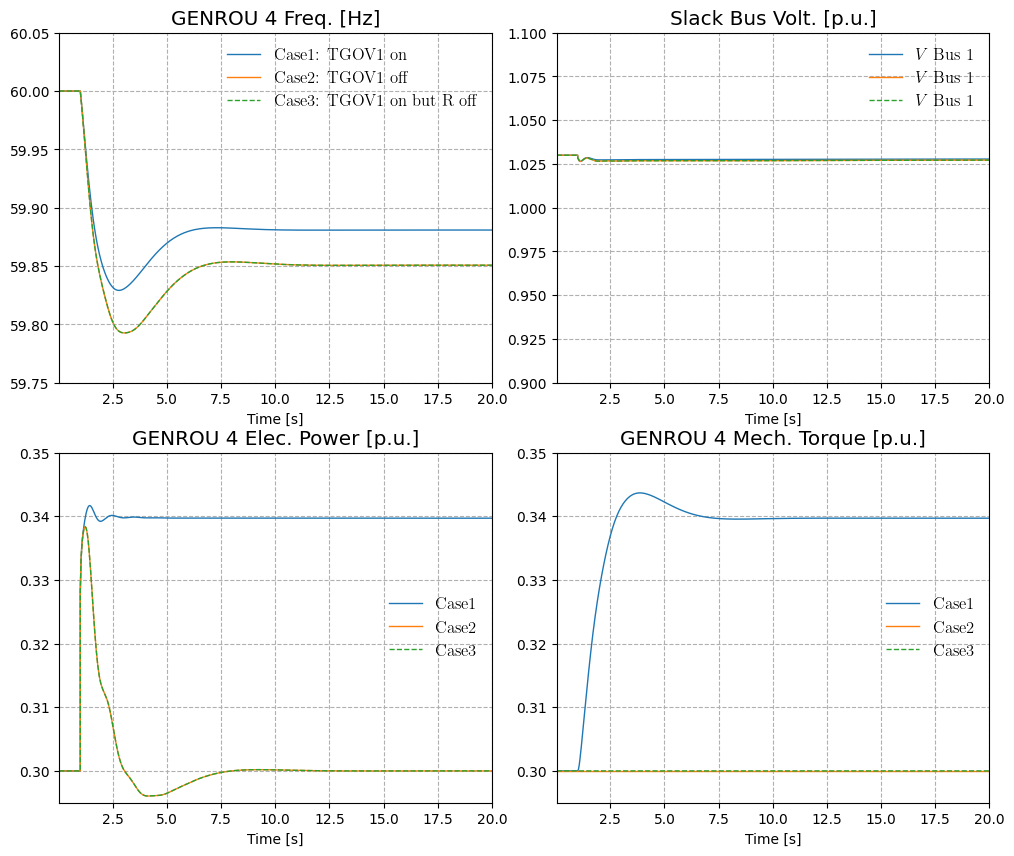

In [7]:
plt.style.use(['default'])
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.2, wspace=0.15)

ylabels = ['Case1: TGOV1 on',
           'Case2: TGOV1 off',
           'Case3: TGOV1 on but R off'] 

fmin, fmax =59.75, 60.05
pmin, pmax = 0.295, 0.35

a = (3,)
_ = s1.TDS.plt.plot(s1.GENROU.omega,
                    a=a,
                    ytimes=s1.config.freq,
                    ymin=fmin, ymax=fmax,
                    grid=True, show=False,
                    fig=fig, ax=ax[0, 0],
                    yheader=[ylabels[0]],
                    title='GENROU 4 Freq. [Hz]')
_ = s2.TDS.plt.plot(s2.GENROU.omega,
                    a=a,
                    ytimes=s1.config.freq,
                    grid=False, show=False,
                    fig=fig, ax=ax[0, 0],
                    yheader=[ylabels[1]])
_ = s3.TDS.plt.plot(s3.GENROU.omega,
                    a=a,
                    ytimes=s1.config.freq,
                    grid=False, show=False,
                    fig=fig, ax=ax[0, 0],
                    linestyles=['--'],
                    yheader=[ylabels[2]])

a = s1.Bus.idx2uid(s1.Slack.bus.v)
_ = s1.TDS.plt.plot(s1.Bus.v,
                    a=a,
                    grid=True, show=False,
                    ymin=0.9, ymax=1.1,
                    fig=fig, ax=ax[0, 1],
                    title='Slack Bus Volt. [p.u.]')
_ = s2.TDS.plt.plot(s2.Bus.v,
                    a=a,
                    grid=False, show=False,
                    fig=fig, ax=ax[0, 1])
_ = s3.TDS.plt.plot(s3.Bus.v,
                    a=a,
                    grid=False, show=False,
                    linestyles=['--'],
                    fig=fig, ax=ax[0, 1])

a = (3,)
_ = s1.TDS.plt.plot(s2.GENROU.Pe,
                    a=a,
                    grid=True, show=False,
                    ymin=pmin, ymax=pmax,
                    fig=fig, ax=ax[1, 0],
                    title='GENROU 4 Elec. Power [p.u.]',
                    yheader=['Case1'])
_ = s2.TDS.plt.plot(s2.GENROU.Pe,
                    a=a,
                    grid=False, show=False,
                    fig=fig, ax=ax[1, 0],
                    yheader=['Case2'])
_ = s3.TDS.plt.plot(s3.GENROU.Pe,
                    a=a,
                    grid=False, show=False,
                    fig=fig, ax=ax[1, 0],
                    linestyles=['--'],
                    yheader=['Case3'])

_ = s1.TDS.plt.plot(s2.GENROU.tm,
                    a=a,
                    ymin=pmin, ymax=pmax,
                    grid=True, show=False,
                    fig=fig, ax=ax[1, 1],
                    title='GENROU 4 Mech. Torque [p.u.]',
                    yheader=['Case1'])
_ = s2.TDS.plt.plot(s2.GENROU.tm,
                    a=a,
                    grid=False, show=False,
                    fig=fig, ax=ax[1, 1],
                    yheader=['Case2'])
_ = s3.TDS.plt.plot(s3.GENROU.tm,
                    a=a,
                    grid=False, show=False,
                    fig=fig, ax=ax[1, 1],
                    linestyles=['--'],
                    yheader=['Case3'])

Observations from this example:

1. Mechanical torque from TurbineGov remains unchanged if the governor is off or Speed regulation gain (R) is very large.
2. For a synchronous generator, electrical power is not always equal to mechanical torque, during transients.